In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Binarizer
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix
%matplotlib inline

In [7]:
import os
print(os.listdir("../dataset"))

['aps_failure_training_set_processed_8bit.csv', '.DS_Store', 'aps_failure_test_set.csv', 'aps_failure_test_set_processed_8bit.csv', 'aps_failure_training_set.csv']


In [9]:
df = pd.read_csv('../dataset/aps_failure_training_set_processed_8bit.csv')

### Usar todas las columnas menos las columnas 'class' como features

In [10]:
features = df.drop(['class'], axis=1)
target = df['class']

# split dataset into train and dev set 90:10 %
f_train, f_dev, t_train, t_dev = train_test_split(features, target, test_size=0.1, random_state=42)

In [11]:
np.unique(target)

array([-0.9921875,  0.9921875])

### Como se usan numeros reales, se necesita binarizar en dos clases: 0 normal 1 falla

In [12]:
# threshold classes into 0 and 1(failure)
lb = Binarizer()
lb.fit(t_train.values.reshape(-1, 1))
t_train_bi = lb.transform(t_train.values.reshape(-1, 1))
t_dev_bi = lb.transform(t_dev.values.reshape(-1, 1))

In [13]:
np.unique(t_train_bi)

array([0., 1.])

### Para usar PCS necesitamos normalizar la data ya que se encuentra escalada

In [16]:
# normalize using standard method
scaler = StandardScaler()
scaler.fit(f_train)
f_nor_train = scaler.transform(f_train)
f_nor_dev = scaler.transform(f_dev)

# select principle components by PCA
pca = PCA(n_components=60)
pca.fit(f_nor_train)
f_pca_train = pca.transform(f_nor_train)
f_pca_dev = pca.transform(f_nor_dev)

### Seleccionamos los 60 componentes principales para transformar la data original 

<BarContainer object of 60 artists>

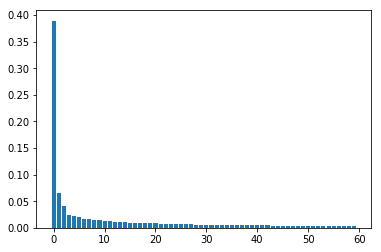

In [22]:
# varince of principle components
plt.bar(range(60),pca.explained_variance_ratio_)


### Generamos el training and test set

In [18]:
# make a training and dev set
X_train = f_pca_train
X_dev = f_pca_dev
y_train = t_train_bi.reshape(-1,1)
y_dev = t_dev_bi.reshape(-1,1)

### Entrenamos Linear Regression

In [19]:
LR = LinearRegression()
LR.fit(X_train, y_train)
prediction = LR.predict(X_dev)
pred = (prediction > 0.5).astype(int)
print(classification_report(y_dev, pred))

             precision    recall  f1-score   support

        0.0       0.99      1.00      0.99      5895
        1.0       0.81      0.36      0.50       105

avg / total       0.99      0.99      0.98      6000



In [20]:
print(confusion_matrix(y_dev, pred))

[[5886    9]
 [  67   38]]
